# structflo-cser — Quickstart

This notebook walks through the **Chemical Structure + Label Extraction** pipeline
step-by-step, then shows the one-liner convenience API.

**Pipeline stages:**
1. **Detect** — YOLO finds chemical structures and compound labels
2. **Match** — Hungarian algorithm pairs each structure with its nearest label
3. **Extract** — DECIMER converts structure crops → SMILES; EasyOCR reads label text

> Requires trained weights at `runs/labels_detect/yolo11l_panels/weights/best.pt`

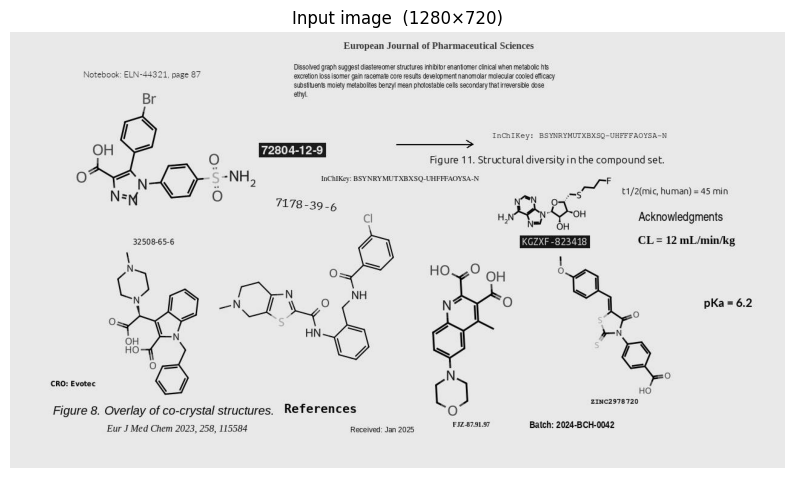

In [13]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image

# Choose a test image (change the filename as needed)
IMAGE_PATH = Path("notebook-data/syn-1.jpg")
assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"

img = Image.open(IMAGE_PATH).convert("RGB")
plt.figure(figsize=(10, 14))
plt.imshow(img)
plt.axis("off")
plt.title(f"Input image  ({img.width}×{img.height})")
plt.show()

## Part 1 — Step-by-step pipeline

### 1a. Create the pipeline

The pipeline is lazy — YOLO weights, DECIMER, and EasyOCR are only loaded on first use.

In [14]:
from structflo.cser.pipeline import ChemPipeline, HungarianMatcher

# Create pipeline — no tiling for this small demo image, match within 500px
pipeline = ChemPipeline(
    tile=False,
    conf=0.01,
    matcher=HungarianMatcher(max_distance=500),
)
print("Pipeline created (models not loaded yet)")

Pipeline created (models not loaded yet)


### 1b. Detect — find structures and labels

`pipeline.detect()` runs YOLO and returns a flat list of `Detection` objects (class 0 = structure, class 1 = label).

In [15]:
detections = pipeline.detect(IMAGE_PATH)

n_struct = sum(1 for d in detections if d.class_id == 0)
n_label  = sum(1 for d in detections if d.class_id == 1)
print(f"Found {n_struct} structures and {n_label} labels  ({len(detections)} total detections)")

Found 6 structures and 6 labels  (12 total detections)


### Visualise detections

Green = chemical structure, Blue = compound label.

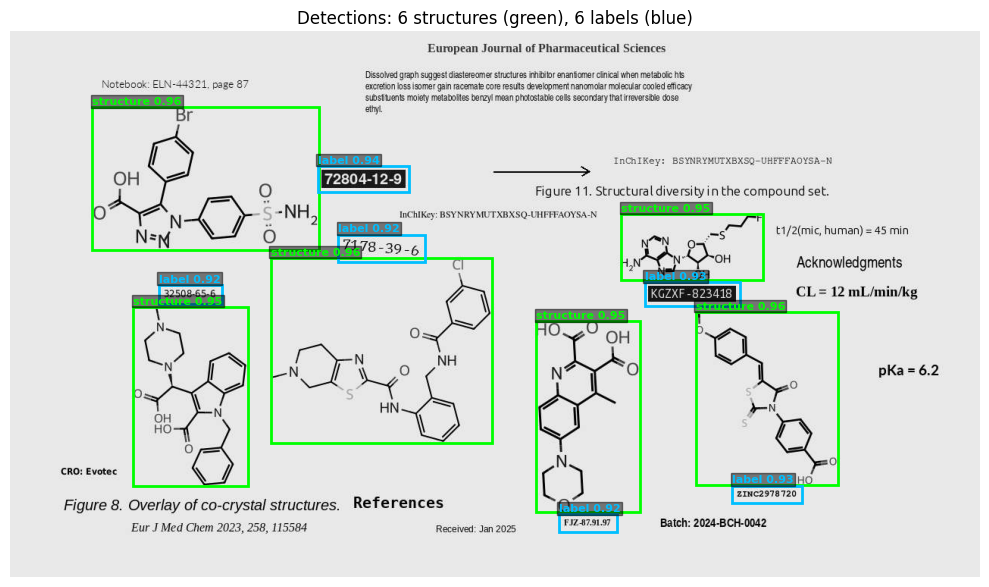

In [16]:
CLASS_COLORS = {0: "lime", 1: "deepskyblue"}
CLASS_NAMES  = {0: "structure", 1: "label"}

fig, ax = plt.subplots(1, 1, figsize=(10, 14))
ax.imshow(img)

for det in detections:
    b = det.bbox
    color = CLASS_COLORS[det.class_id]
    rect = mpatches.Rectangle(
        (b.x1, b.y1), b.width, b.height,
        linewidth=2, edgecolor=color, facecolor="none",
    )
    ax.add_patch(rect)
    ax.text(
        b.x1, b.y1 - 4,
        f"{CLASS_NAMES[det.class_id]} {det.conf:.2f}",
        color=color, fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

ax.set_title(f"Detections: {n_struct} structures (green), {n_label} labels (blue)")
ax.axis("off")
plt.tight_layout()
plt.show()

### 1c. Match — pair structures with labels

`pipeline.match()` uses the Hungarian algorithm to optimally pair each structure with its nearest label by centroid distance.

In [17]:
pairs = pipeline.match(detections)
print(f"Matched {len(pairs)} structure–label pairs\n")

for i, p in enumerate(pairs):
    sc = p.structure.bbox.centroid
    lc = p.label.bbox.centroid
    print(f"  Pair {i}: distance={p.match_distance:.0f}px  "
          f"structure@({sc[0]:.0f},{sc[1]:.0f})  label@({lc[0]:.0f},{lc[1]:.0f})")

Matched 6 structure–label pairs

  Pair 0: distance=135px  structure@(490,421)  label@(489,285)
  Pair 1: distance=208px  structure@(258,194)  label@(466,195)
  Pair 2: distance=126px  structure@(998,484)  label@(999,610)
  Pair 3: distance=135px  structure@(238,481)  label@(237,346)
  Pair 4: distance=62px  structure@(899,284)  label@(900,346)
  Pair 5: distance=140px  structure@(762,508)  label@(762,648)


### Visualise matched pairs

Orange lines connect each structure to its matched label.

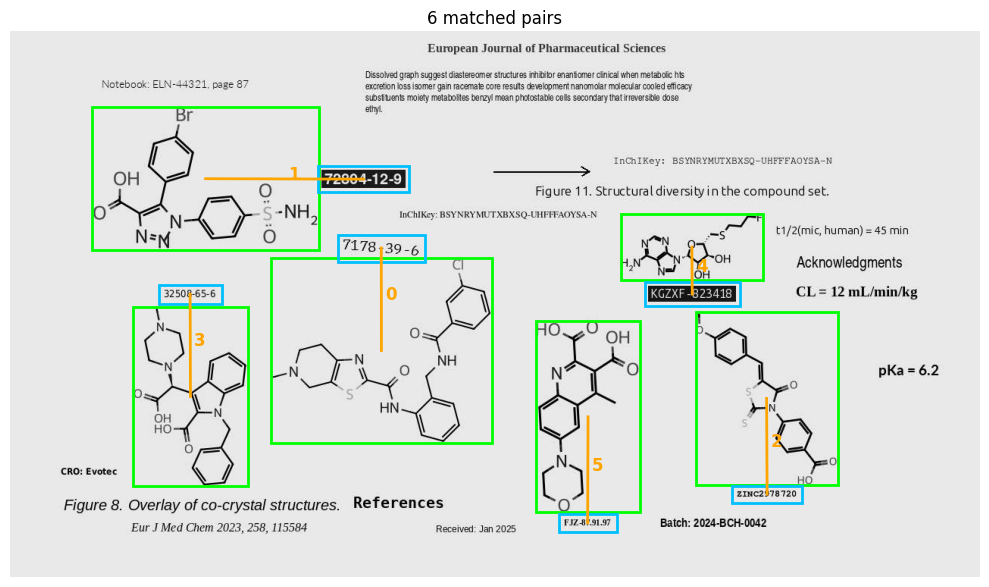

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
ax.imshow(img)

for i, p in enumerate(pairs):
    # Draw structure box (green) and label box (blue)
    for det, color in [(p.structure, "lime"), (p.label, "deepskyblue")]:
        b = det.bbox
        ax.add_patch(mpatches.Rectangle(
            (b.x1, b.y1), b.width, b.height,
            linewidth=2, edgecolor=color, facecolor="none",
        ))

    # Draw pairing line (orange)
    sc = p.structure.bbox.centroid
    lc = p.label.bbox.centroid
    ax.plot([sc[0], lc[0]], [sc[1], lc[1]], color="orange", linewidth=2)
    mid_x, mid_y = (sc[0] + lc[0]) / 2, (sc[1] + lc[1]) / 2
    ax.text(mid_x + 5, mid_y, str(i), color="orange", fontsize=12, weight="bold")

ax.set_title(f"{len(pairs)} matched pairs")
ax.axis("off")
plt.tight_layout()
plt.show()

### 1d. Show cropped regions for each pair

For each matched pair, we crop the structure and label regions from the original image.

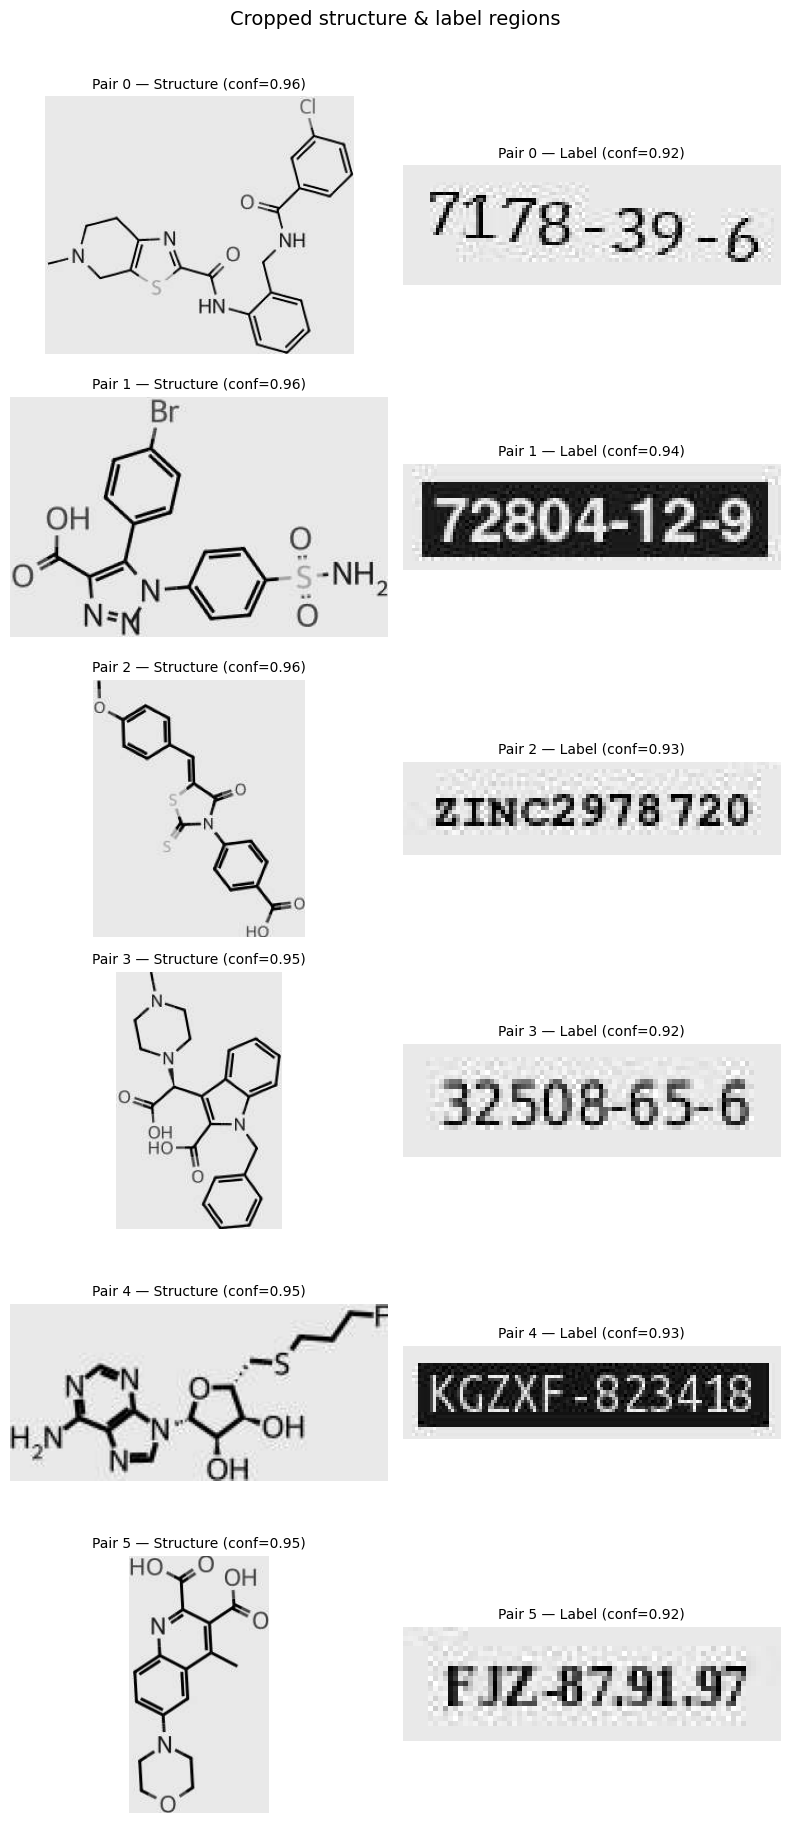

In [19]:
n_pairs = len(pairs)
fig, axes = plt.subplots(n_pairs, 2, figsize=(8, 3 * n_pairs))
if n_pairs == 1:
    axes = axes.reshape(1, -1)

for i, p in enumerate(pairs):
    # Crop structure
    sb = p.structure.bbox
    struct_crop = img.crop((int(sb.x1), int(sb.y1), int(sb.x2), int(sb.y2)))
    axes[i, 0].imshow(struct_crop)
    axes[i, 0].set_title(f"Pair {i} — Structure (conf={p.structure.conf:.2f})", fontsize=10)
    axes[i, 0].axis("off")

    # Crop label
    lb = p.label.bbox
    label_crop = img.crop((int(lb.x1), int(lb.y1), int(lb.x2), int(lb.y2)))
    axes[i, 1].imshow(label_crop)
    axes[i, 1].set_title(f"Pair {i} — Label (conf={p.label.conf:.2f})", fontsize=10)
    axes[i, 1].axis("off")

plt.suptitle("Cropped structure & label regions", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 1e. Extract — SMILES and label text

`pipeline.enrich()` runs DECIMER on each structure crop and EasyOCR on each label crop, populating `pair.smiles` and `pair.label_text`.

In [20]:
enriched_pairs = pipeline.enrich(pairs, IMAGE_PATH)

for i, p in enumerate(enriched_pairs):
    print(f"Pair {i}:")
    print(f"  SMILES:     {p.smiles}")
    print(f"  Label text: {p.label_text}")
    print(f"  Distance:   {p.match_distance:.0f}px")
    print()

Pair 0:
  SMILES:     CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)C4=CC=CC(=C4)Cl
  Label text: 7178-39-6
  Distance:   135px

Pair 1:
  SMILES:     C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br
  Label text: 72804-12-9
  Distance:   208px

Pair 2:
  SMILES:     COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)C(=S)S2
  Label text: ZINC2978 720
  Distance:   126px

Pair 3:
  SMILES:     CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C4=CC=CC=C42)C(=O)O
  Label text: 32508-65-6
  Distance:   135px

Pair 4:
  SMILES:     C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=CN=C3N)O1)O)O
  Label text: KGZXF -823418
  Distance:   62px

Pair 5:
  SMILES:     CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O
  Label text: FJZ 87.91,97
  Distance:   140px



### 1f. Results as a DataFrame

In [21]:
df = ChemPipeline.to_dataframe(enriched_pairs)
df

,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,smiles,label_text
0,"[343.3332824707031, 298.47149658203125, 635.89...",0.9573,"[432.1730041503906, 267.5862121582031, 546.668...",0.9219,135.19,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
1,"[108.32279205322266, 99.74943542480469, 406.93...",0.9572,"[405.439208984375, 177.31838989257812, 526.623...",0.9373,208.40,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,72804-12-9
2,"[904.202392578125, 369.7506408691406, 1091.622...",0.9563,"[952.1218872070312, 598.8056640625, 1045.03320...",0.9263,126.25,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
3,"[161.93466186523438, 363.0390930175781, 313.34...",0.9547,"[195.62179565429688, 333.852783203125, 278.739...",0.9185,134.86,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
4,"[806.03076171875, 240.70889282226562, 992.5532...",0.9537,"[837.0864868164062, 330.5846862792969, 962.476...",0.9337,61.96,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
5,"[693.6105346679688, 382.15234375, 830.99865722...",0.9514,"[723.584716796875, 636.6728515625, 799.9077148...",0.9216,139.98,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,"FJZ 87.91,97"


---

## Part 2 — Full pipeline in one call

Everything above (detect → match → enrich) can be done in a single `process()` call.

In [22]:
# One-liner: detect + match + extract SMILES & OCR in a single call
results = pipeline.process(IMAGE_PATH)

# View as DataFrame
ChemPipeline.to_dataframe(results)

,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,smiles,label_text
0,"[343.3332824707031, 298.47149658203125, 635.89...",0.9573,"[432.1730041503906, 267.5862121582031, 546.668...",0.9219,135.19,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
1,"[108.32279205322266, 99.74943542480469, 406.93...",0.9572,"[405.439208984375, 177.31838989257812, 526.623...",0.9373,208.40,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,72804-12-9
2,"[904.202392578125, 369.7506408691406, 1091.622...",0.9563,"[952.1218872070312, 598.8056640625, 1045.03320...",0.9263,126.25,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
3,"[161.93466186523438, 363.0390930175781, 313.34...",0.9547,"[195.62179565429688, 333.852783203125, 278.739...",0.9185,134.86,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
4,"[806.03076171875, 240.70889282226562, 992.5532...",0.9537,"[837.0864868164062, 330.5846862792969, 962.476...",0.9337,61.96,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
5,"[693.6105346679688, 382.15234375, 830.99865722...",0.9514,"[723.584716796875, 636.6728515625, 799.9077148...",0.9216,139.98,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,"FJZ 87.91,97"


### Export to JSON

In [23]:
print(ChemPipeline.to_json(results))

[
  {
    "structure_bbox": [
      343.3332824707031,
      298.47149658203125,
      635.892578125,
      542.6845703125
    ],
    "structure_conf": 0.9573,
    "label_bbox": [
      432.1730041503906,
      267.5862121582031,
      546.6683959960938,
      303.18402099609375
    ],
    "label_conf": 0.9219,
    "match_distance": 135.19,
    "smiles": "CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)C4=CC=CC(=C4)Cl",
    "label_text": "7178-39-6"
  },
  {
    "structure_bbox": [
      108.32279205322266,
      99.74943542480469,
      406.9380187988281,
      288.082763671875
    ],
    "structure_conf": 0.9572,
    "label_bbox": [
      405.439208984375,
      177.31838989257812,
      526.623779296875,
      211.6856689453125
    ],
    "label_conf": 0.9373,
    "match_distance": 208.4,
    "smiles": "C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br",
    "label_text": "72804-12-9"
  },
  {
    "structure_bbox": [
      904.202392578125,
      369.7506408691406,
      1091.62

### Final annotated image with extracted info

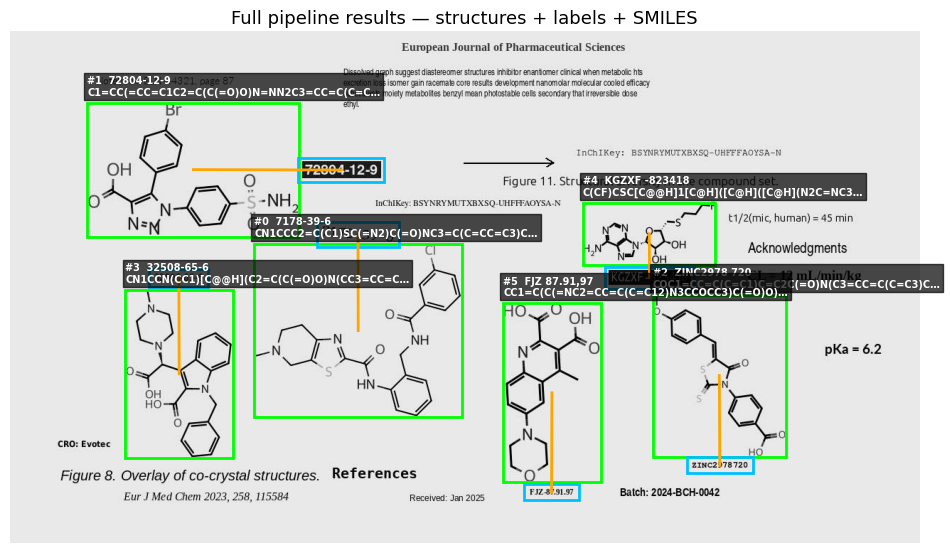

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
ax.imshow(img)

for i, p in enumerate(results):
    # Structure box (green)
    sb = p.structure.bbox
    ax.add_patch(mpatches.Rectangle(
        (sb.x1, sb.y1), sb.width, sb.height,
        linewidth=2, edgecolor="lime", facecolor="none",
    ))

    # Label box (blue)
    lb = p.label.bbox
    ax.add_patch(mpatches.Rectangle(
        (lb.x1, lb.y1), lb.width, lb.height,
        linewidth=2, edgecolor="deepskyblue", facecolor="none",
    ))

    # Pairing line
    sc = sb.centroid
    lc = lb.centroid
    ax.plot([sc[0], lc[0]], [sc[1], lc[1]], color="orange", linewidth=2)

    # Annotation with extracted info
    smiles_short = (p.smiles[:40] + "…") if p.smiles and len(p.smiles) > 40 else (p.smiles or "—")
    label_txt = p.label_text or "—"
    annotation = f"#{i}  {label_txt}\n{smiles_short}"
    ax.text(
        sb.x1, sb.y1 - 8, annotation,
        color="white", fontsize=7, weight="bold",
        bbox=dict(facecolor="black", alpha=0.7, pad=2),
        verticalalignment="bottom",
    )

ax.set_title("Full pipeline results — structures + labels + SMILES", fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()